In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
file_path = 'data_input_auto/山东柴油裂解差.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)

sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')

fill_methods = {  
    '全球因子/全球铜矿商指数': 'interpolate',  
    '房价因子/中国房价收入比': 'interpolate'
} 
sheet = fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.set_index('Date', inplace=True)

# 把数据变长30天 向后预测 30天
full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max() + pd.Timedelta(days=30), freq='B')
sheet_daily = sheet.reindex(full_date_range)

# 把数据后移到 77天全球因子/全球铜矿商指数_提前77天
sheet_daily['全球因子/全球铜矿商指数_提前77天'] = sheet_daily['全球因子/全球铜矿商指数'].shift(77)
sheet_daily['全球因子/全球铜矿商指数_提前77天_逆序'] = reverse_column(sheet_daily, '全球因子/全球铜矿商指数_提前77天')
sheet_daily['房价因子/中国房价收入比_提前77天'] = sheet_daily['房价因子/中国房价收入比'].shift(77)

In [4]:
# 转换date index    
sheet_daily = sheet_daily.reset_index()
sheet_daily.rename(columns={'index': 'Date'}, inplace=True)
# 筛选数据
sheet_daily = sheet_daily[sheet_daily['Date'] >= '2021-08-10']

In [5]:
last_day = sheet_daily['Date'][sheet_daily['山东柴油裂解差/30DMA/日频'].last_valid_index()]
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['山东柴油裂解差/30DMA/日频'].notna()]

In [6]:
sheet_daily 

,Date,山东柴油裂解差/30DMA/日频,全球因子/全球铜矿商指数,房价因子/中国房价收入比,全球因子/全球铜矿商指数_提前77天,全球因子/全球铜矿商指数_提前77天_逆序,房价因子/中国房价收入比_提前77天
2446,2021-08-10,352.8026,130.7190,0.233377,134.9968,90.2909,0.201483
2447,2021-08-11,356.7483,132.6612,0.233145,140.2654,85.0223,0.202133
2448,2021-08-12,361.3590,132.1678,0.232913,140.0628,85.2249,0.202350
2449,2021-08-13,365.2310,133.6744,0.232681,139.7120,85.5757,0.202567
2450,2021-08-16,373.4679,130.3293,0.231984,140.4172,84.8705,0.202783
...,...,...,...,...,...,...,...
3391,2025-03-25,NaN,NaN,NaN,160.8800,64.4077,0.187897
3392,2025-03-26,NaN,NaN,NaN,165.5411,59.7466,0.189145
3393,2025-03-27,NaN,NaN,NaN,163.4099,61.8778,0.189561
3394,2025-03-28,NaN,NaN,NaN,163.9841,61.3036,0.189977


In [7]:
last_day

Timestamp('2025-02-28 00:00:00')

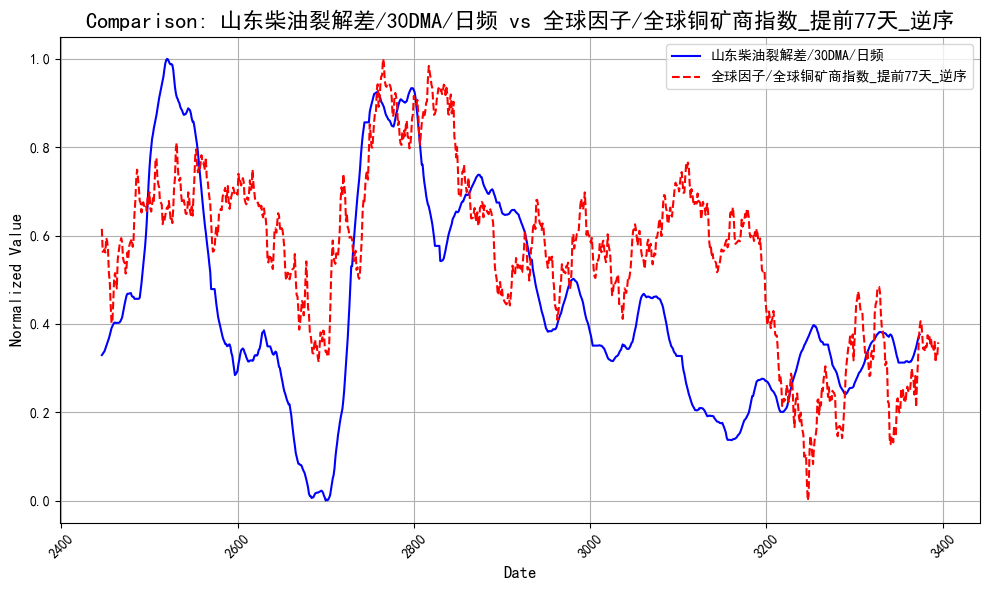

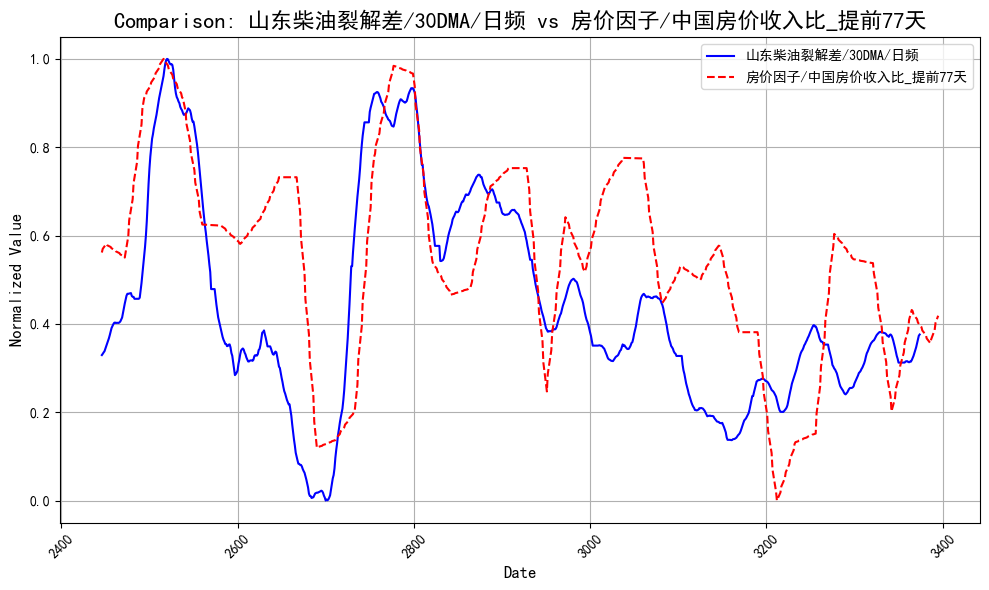

In [8]:
plot_comparison_multiple(
    sheet_daily, 
    main_col='山东柴油裂解差/30DMA/日频', 
    compare_cols=[ '全球因子/全球铜矿商指数_提前77天_逆序','房价因子/中国房价收入比_提前77天']
) 

In [9]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 20
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[['全球因子/全球铜矿商指数_提前77天_逆序','房价因子/中国房价收入比_提前77天']]
y_train = train_data['山东柴油裂解差/30DMA/日频']
X_test = test_data[['全球因子/全球铜矿商指数_提前77天_逆序','房价因子/中国房价收入比_提前77天']]
y_test = test_data['山东柴油裂解差/30DMA/日频']

X_future = future_data[['全球因子/全球铜矿商指数_提前77天_逆序','房价因子/中国房价收入比_提前77天']]

In [10]:
# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 归一化特征数据
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 定义并训练 XGBRegressor 模型
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.08, max_depth=2, subsample=0.9, colsample_bytree=0.8)
xgb.fit(X_train_scaled, y_train)


# 训练集和测试集的预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

# 计算 MSE 和 R^2 分数
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")

# 未来预测
'''
X_all = sheet_daily[sheet_daily['Date'] <= last_day][['全球因子/全球铜矿商指数_提前77天_逆序','房价因子/中国房价收入比_提前77天']]
y_all = sheet_daily[sheet_daily['Date'] <= last_day]['山东柴油裂解差/30DMA/日频']

# 归一化所有历史特征数据
X_all_scaled = scaler.fit_transform(X_all)

# 使用所有历史数据重新训练模型
xgb.fit(X_all_scaled, y_all)
'''

y_future_pred = xgb.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

Train MSE: 34323.79697233052, Train R^2: 0.7140109097171239
Test MSE: 8714.71075463181, Test R^2: -8.280858328202937


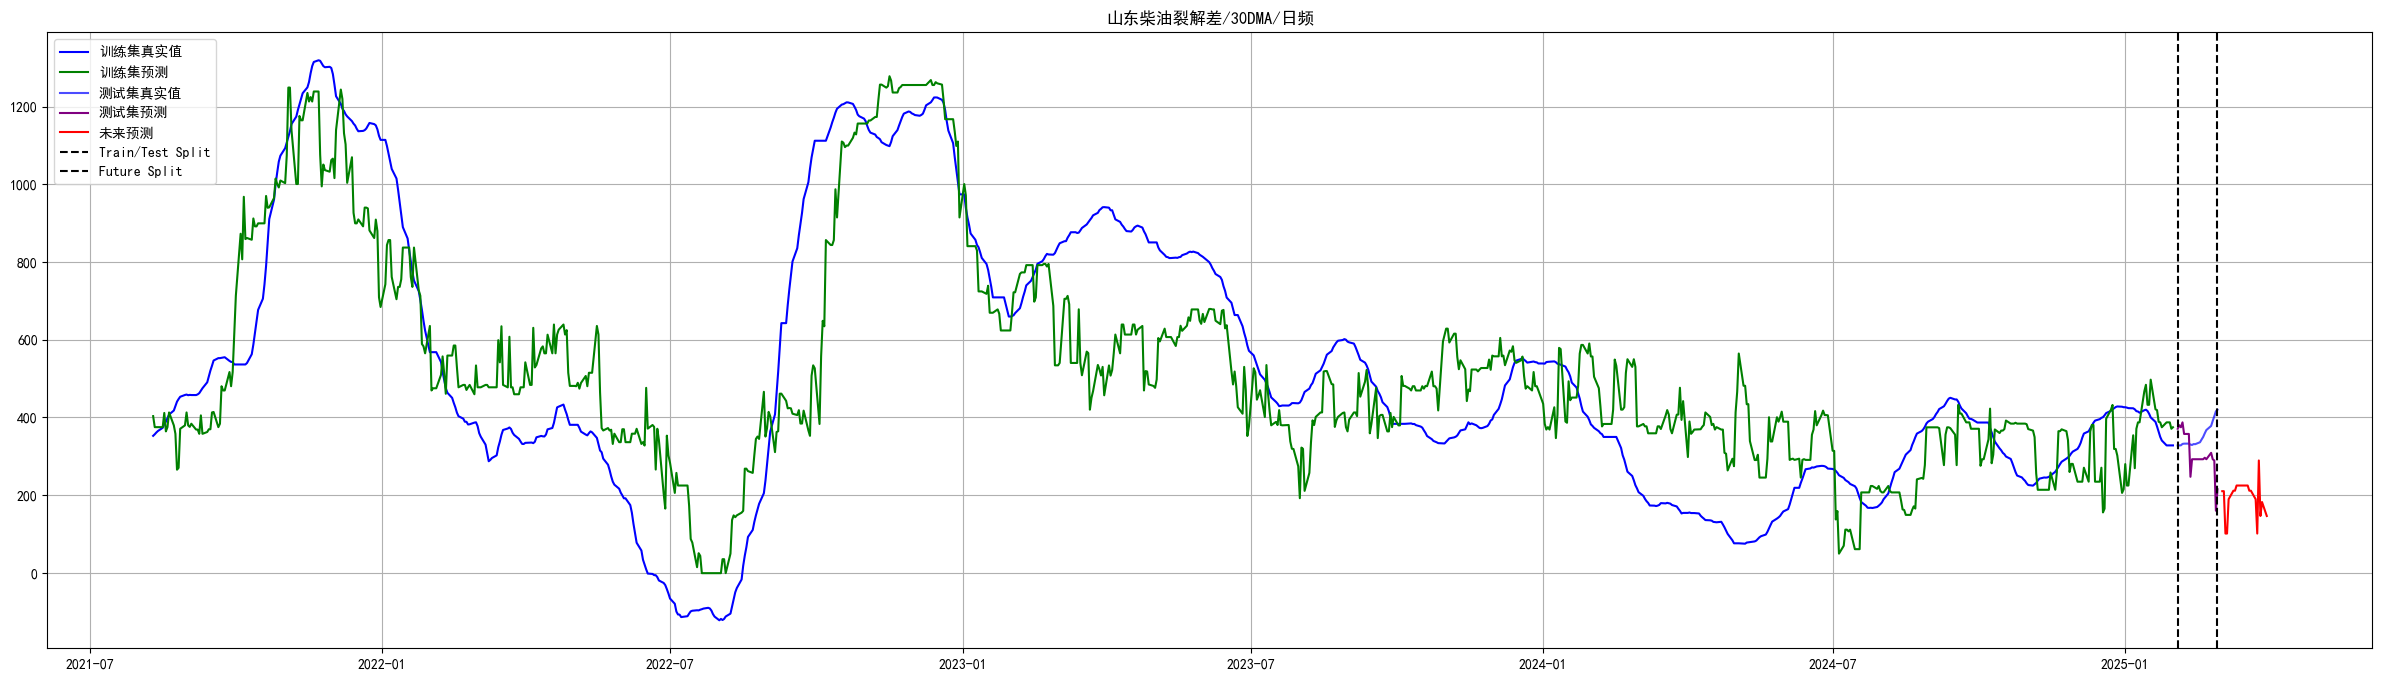

In [11]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('山东柴油裂解差/30DMA/日频')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 创建一个包含2018年之后数据的DataFrame
train_pred_df = pd.DataFrame({
    'Date': train_data['Date'],
    '预测值': y_train_pred
})
# train_pred_df = train_pred_df[train_pred_df['Date'].dt.year >= 2018]

test_pred_df = pd.DataFrame({
    'Date': test_data['Date'],
    '预测值': test_data['预测值']
})

future_pred_df = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值']
})

# 合并所有预测数据
all_predictions = pd.concat([train_pred_df, test_pred_df, future_pred_df])
all_predictions = all_predictions.rename(columns={'预测值': '山东柴油裂解差/30DMA/日频_预测'})

all_predictions

,Date,山东柴油裂解差/30DMA/日频_预测
2446,2021-08-10,403.484741
2447,2021-08-11,375.138611
2448,2021-08-12,375.138611
2449,2021-08-13,375.138611
2450,2021-08-16,375.138611
...,...,...
3391,2025-03-25,101.376579
3392,2025-03-26,289.410034
3393,2025-03-27,146.542831
3394,2025-03-28,182.496964


In [13]:
# 筛选2024年的数据
data_2024 = all_predictions[all_predictions['Date'].dt.year >= 2024].copy()

# 将日期设置为索引
data_2024.set_index('Date', inplace=True)

# 按月重采样并计算平均值
monthly_data = data_2024.resample('ME').mean()

# 重置索引
monthly_data.reset_index(inplace=True)

# 将日期格式化为年月
monthly_data['Date'] = monthly_data['Date'].dt.strftime('%Y-%m-%d')

# 保存到CSV文件
monthly_data.to_csv('data_output_auto/山东柴油裂解差_2024月度预测.csv', index=False, encoding='utf-8-sig')
print('数据已保存到: data_output_auto/山东柴油裂解差_2024月度预测.csv')

print(monthly_data)

数据已保存到: data_output_auto/山东柴油裂解差_2024月度预测.csv
          Date  山东柴油裂解差/30DMA/日频_预测
0   2024-01-31           470.195404
1   2024-02-29           461.763519
2   2024-03-31           388.819824
3   2024-04-30           353.722260
4   2024-05-31           374.004669
5   2024-06-30           341.266754
6   2024-07-31           159.055389
7   2024-08-31           215.548721
8   2024-09-30           370.837402
9   2024-10-31           359.454742
10  2024-11-30           284.964417
11  2024-12-31           283.746979
12  2025-01-31           378.814850
13  2025-02-28           304.355408
14  2025-03-31           193.590561


In [14]:
future_pred_df_rename = future_pred_df.rename(columns={'预测值': '山东柴油裂解差/30DMA/日频_预测'})
future_pred_df_rename.to_csv('data_output_auto/山东柴油裂解差_未来日度预测.csv', index=False)
print('未来预测数据已保存到: data_output_auto/山东柴油裂解差_未来日度预测.csv')
future_pred_df_rename.head()

未来预测数据已保存到: data_output_auto/山东柴油裂解差_未来日度预测.csv


,Date,山东柴油裂解差/30DMA/日频_预测
3375,2025-03-03,210.391357
3376,2025-03-04,210.391357
3377,2025-03-05,101.376579
3378,2025-03-06,101.376579
3379,2025-03-07,189.705994


---

In [15]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '山东柴油裂解差/30DMA/日频']]
test_actual = test_data[['Date', '山东柴油裂解差/30DMA/日频']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/山东柴油裂解差_合并数据.xlsx', index=False,float_format = '%.2f')
merged_df

,Date,实际值,预测值
585,2025/03/31,NaN,146.542831
584,2025/03/28,NaN,182.496964
583,2025/03/27,NaN,146.542831
582,2025/03/26,NaN,289.410034
581,2025/03/25,NaN,101.376579
...,...,...,...
4,2023/01/06,873.3517,NaN
3,2023/01/05,895.8477,NaN
2,2023/01/04,914.8238,NaN
1,2023/01/03,939.2672,NaN


In [16]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', '山东柴油裂解差/30DMA/日频']],
    test_data[['Date', '山东柴油裂解差/30DMA/日频']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
monthly_df.to_excel('eta/山东柴油裂解差_月度数据.xlsx', index=False,float_format='%.2f')
monthly_df.head()

,Date,实际值,预测值
26,2025/03/31,NaN,193.590561
25,2025/02/28,353.471275,304.355408
24,2025/01/31,386.521748,378.814850
23,2024/12/31,389.258532,283.746979
22,2024/11/30,262.065633,284.964417
